## 导包

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta
import sklearn

## 设置与读取

In [2]:
train_data = pd.read_csv('data/new_train_public.csv')
test_public = pd.read_csv('data/test_public.csv')
train_inte = pd.read_csv('data/train_internet.csv')

pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)

## 模型模块

In [3]:
def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])    #行数
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.08,
            num_leaves=2**5,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,
#             max_bin=250,
            reg_alpha=.3,
            reg_lambda=.3,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df
    
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [4]:
def workYearDIc(x):
    if str(x)=='nan':
        return -1
    x = x.replace('< 1','0')
    return int(re.search('(\d+)', x).group())

def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'

class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}
timeMax = pd.to_datetime('1-Dec-21')

## 数据预处理

In [5]:
# 特征融合
train_data['loan_year']=train_data['total_loan']/train_data['year_of_loan']
test_public['loan_year']=test_public['total_loan']/test_public['year_of_loan']
train_inte['loan_year']=train_inte['total_loan']/train_inte['year_of_loan']

train_data['early_ratio']=train_data['early_return_amount']/train_data['total_loan']
test_public['early_ratio']=test_public['early_return_amount']/test_public['total_loan']
train_inte['early_ratio']=train_inte['early_return_amount']/train_inte['total_loan']

train_data['early_times_ratio']=train_data['early_return']/train_data['year_of_loan']
test_public['early_times_ratio']=test_public['early_return']/test_public['year_of_loan']
train_inte['early_times_ratio']=train_inte['early_return']/train_inte['year_of_loan']

train_data['recircle_ratio']=train_data['recircle_b']/train_data['total_loan']
test_public['recircle_ratio']=test_public['recircle_b']/test_public['total_loan']
train_inte['recircle_ratio']=train_inte['recircle_b']/train_inte['total_loan']

train_data['recircle_amt']=train_data['recircle_u']*train_data['total_loan']
test_public['recircle_amt']=test_public['recircle_u']*test_public['total_loan']
train_inte['recircle_amt']=train_inte['recircle_u']*train_inte['total_loan']

In [6]:
train_data['work_year'] = train_data['work_year'].map(workYearDIc)    #缺失值填充为-1 其他和baseline一样
test_public['work_year'] = test_public['work_year'].map(workYearDIc)
train_data['class'] = train_data['class'].map(class_dict)    #从1开始编码 但顺序与baseline相同
test_public['class'] = test_public['class'].map(class_dict)

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))    #缺年份补2001年 缺日补1号
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))
#对时间大于 2021-12-01 的 -100 年
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+  pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])

#Internet数据处理
train_inte['work_year'] = train_inte['work_year'].map(workYearDIc)
train_inte['class'] = train_inte['class'].map(class_dict)
train_inte['earlies_credit_mon'] = pd.to_datetime(train_inte['earlies_credit_mon'])
train_inte['issue_date'] = pd.to_datetime(train_inte['issue_date'])

## 时间特征

In [7]:
train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year

# internet数据
train_inte['issue_date_month'] = train_inte['issue_date'].dt.month
train_inte['issue_date_dayofweek'] = train_inte['issue_date'].dt.dayofweek
train_inte['earliesCreditMon'] = train_inte['earlies_credit_mon'].dt.month
train_inte['earliesCreditYear'] = train_inte['earlies_credit_mon'].dt.year

## 自然编码

In [8]:
cat_cols = ['employer_type', 'industry']

from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
    
    #Internet处理
    train_inte[col] = lbl.transform(train_inte[col])
    
col_to_drop = ['issue_date', 'earlies_credit_mon']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1 )

# internet处理
train_inte = train_inte.drop(col_to_drop, axis=1 )
tr_cols = set(train_data.columns)
same_col = list(tr_cols.intersection(set(train_inte.columns)))
train_inteSame = train_inte[same_col].copy()

Inte_add_cos = list(tr_cols.difference(set(same_col)))
for col in Inte_add_cos:
    train_inteSame[col] = np.nan

## train 预测 Internet

In [9]:
y = train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=20000413)
oof_preds, IntePre, importances = train_model(train_data, train_inteSame, y, folds)

Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.958934	training's binary_logloss: 0.17591	valid_1's auc: 0.890944	valid_1's binary_logloss: 0.238464
Early stopping, best iteration is:
[67]	training's auc: 0.947219	training's binary_logloss: 0.189413	valid_1's auc: 0.892594	valid_1's binary_logloss: 0.237972
Fold  1 AUC : 0.892594
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.963592	training's binary_logloss: 0.172207	valid_1's auc: 0.885643	valid_1's binary_logloss: 0.241867
Early stopping, best iteration is:
[62]	training's auc: 0.946337	training's binary_logloss: 0.191259	valid_1's auc: 0.889015	valid_1's binary_logloss: 0.239615
Fold  2 AUC : 0.889015
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[45]	training's auc: 0.933543	training's binary_logloss: 0.205565	valid_1's auc: 0.895823	valid_1's binary_logloss: 0.230274
Fold  3 AUC : 0.895823
Training until va

In [11]:
IntePre['isDef'] = train_inte['isDefault']

<ipython-input-11-fdb6375c5692>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IntePre['isDef'] = train_inte['isDefault']


In [13]:
from sklearn.metrics import roc_auc_score
roc_auc_score(IntePre['isDef'],IntePre.isDefault)

0.7287236763518797

In [ ]:
plt.figure(figsize=(16,6))
plt.title("Distribution of Default values IntePre")
sns.distplot(IntePre['isDefault'],color="black", kde=True,bins=120, label='train_data')
# sns.distplot(train_inte[col],color="red", kde=True,bins=120, label='train_inte')
plt.legend();plt.show()

In [16]:
## 选择阈值0.05，从internet表中提取预测小于该概率的样本，并对不同来源的样本赋予来源值
InteId = IntePre.loc[IntePre.isDefault<0.05, 'loan_id'].tolist()

train_data['dataSourse'] = 1
test_public['dataSourse'] = 1
train_inteSame['dataSourse'] = 0
train_inteSame['isDefault'] = train_inte['isDefault']    #重新覆盖为真实标签
use_te = train_inteSame[train_inteSame.loan_id.isin( InteId )].copy()
data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True)

## 模型与输出

In [19]:
train = data[data['isDefault'].notna()]
test  = data[data['isDefault'].isna()]

del data
del train_data,test_public

y = train['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=20000413)
oof_preds, test_preds, importances = train_model(train, test, y, folds)

Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[27]	training's auc: 0.984749	training's binary_logloss: 0.0449168	valid_1's auc: 0.982705	valid_1's binary_logloss: 0.0506317
Fold  1 AUC : 0.982705
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.99022	training's binary_logloss: 0.037496	valid_1's auc: 0.98013	valid_1's binary_logloss: 0.0450421
Early stopping, best iteration is:
[91]	training's auc: 0.989706	training's binary_logloss: 0.0381096	valid_1's auc: 0.980128	valid_1's binary_logloss: 0.0450165
Fold  2 AUC : 0.980128
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[37]	training's auc: 0.98611	training's binary_logloss: 0.0430416	valid_1's auc: 0.979601	valid_1's binary_logloss: 0.0468578
Fold  3 AUC : 0.979601
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[49]	training's auc: 0.986642	training's b

In [21]:
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('submit/final_submission.csv', index=False)

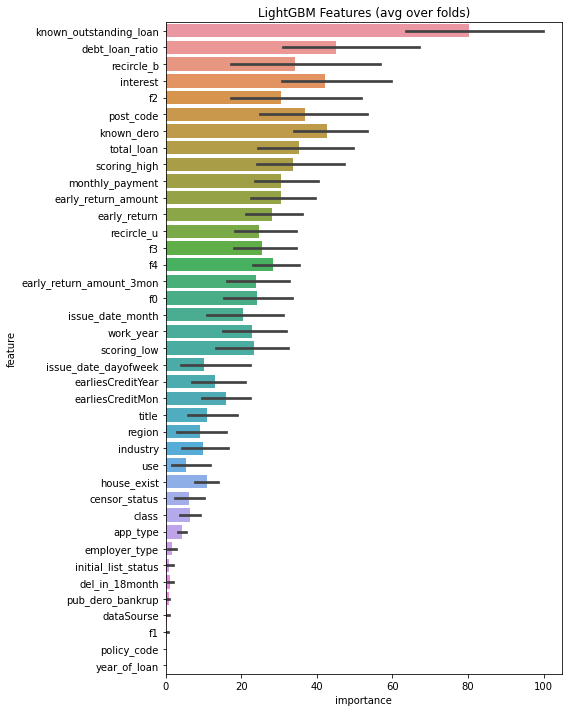

In [23]:
# display_importances(importances)